In [2]:
#1. load labeled data and shuffle(keep trace on id)
#2. cleanData(html, utf-8 unicode)
#3. identify
#4. split with punctuation
#5. token and vectorize
#6. split data 8:2 or 7:3
#7. train a classifier using SVM

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt  
import time

from Utils import utilDataPreprocess, logProcessFuncs
import importlib
importlib.reload(utilDataPreprocess)
importlib.reload(logProcessFuncs)

%matplotlib inline
plt.rcParams["figure.figsize"] = [16,9]
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

                                                body  label
0  string function text event code javascript res...      0
1  firefox internet browser flash sifr explorer h...      0
2  public list int function new warning method va...      0
3  test array value number code language byte exa...      0
4  server file way application user database time...      0


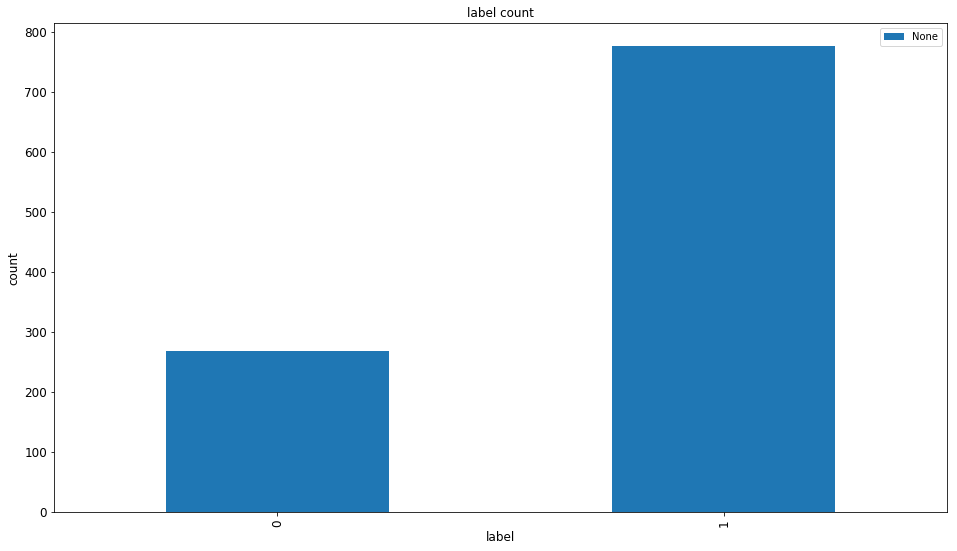

731 314
labels_train [0 1]


In [46]:
### load labeled data 
#Nlogs are from 
#https://ossec-docs.readthedocs.io/en/latest/log_samples/
#http://www.monitorware.com/en/logsamples/

DATAFILES = [
    {"filename":"./Nlogs.csv", "label":0},
    {"filename":"./ossec_testing.csv", "label":1},
    {"filename":"./ossec_rules_keep.csv", "label":1}
]
def loadTrainData():
    data = pd.DataFrame()
    for datafile in DATAFILES:
        filename = datafile["filename"]
        dataTmp = pd.read_csv(filename)
        if "body" not in dataTmp.columns:
            continue
        dataTmp = dataTmp[dataTmp["body"].notnull()]
        dataTmp["body"] = dataTmp["body"].map(logProcessFuncs.cleanTextFunc)
        dataTmp["label"] = datafile["label"]
        data = data.append(dataTmp[["body", "label"]], ignore_index=True)
    return data

df_train_data = loadTrainData()
df_train_data = df_train_data[df_train_data['body'].notnull()]
df_train_data = df_train_data.drop_duplicates(['body'])
print(df_train_data.head())
ax = df_train_data.groupby(['label']).size().plot(kind='bar', title ="label count", legend=True, fontsize=12)
ax.set_xlabel("label", fontsize=12)
ax.set_ylabel("count", fontsize=12)
plt.show()
X,y = df_train_data['body'].tolist(), df_train_data['label'].tolist()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123) # shuffle is True by default
#for test
#X_train, X_test, y_train, y_test = X_train[:350], X_test[:150], y_train[:350], y_test[:150]
print(len(X_train), len(X_test))
labels_train = np.unique(y_train)
print("labels_train", labels_train)

In [47]:
def printNMostInformative(feature_names, coef, N):
    """Prints features with the highest coefficient values, per class"""
    coefs_with_fns = sorted(zip(coef, feature_names))
    #print(coefs_with_fns)
    topClass1 = coefs_with_fns[:N]
    topClass2 = coefs_with_fns[:-(N + 1):-1]
    print("Class 1 best: ")
    for feat in topClass1:
        print(feat)
    print("Class 2 best: ")
    for feat in topClass2:
        print(feat)

In [48]:
def drawROCCurve(y_test, predict):
    print(y_test[:10])
    print(predict[:10])
    fpr, tpr, thresholds = roc_curve(y_test, predict) 
    roc_auc = auc(fpr, tpr)  
    #画图，只需要plt.plot(fpr,tpr),变量roc_auc只是记录auc的值，通过auc()函数能计算出来  
    plt.plot(fpr, tpr, lw=1, label='ROC Curve(AUC = %0.2f)' % (roc_auc))
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
    plt.xlim([-0.05, 1.05])  
    plt.ylim([-0.05, 1.05])  
    plt.xlabel('False Positive Rate')  
    plt.ylabel('True Positive Rate')  
    plt.title('Receiver operating characteristic example')  
    plt.legend(loc="lower right")  
    plt.show()  

In [49]:
def gridSearchCLF(estimator, parameters, X_train, y_train):
    grid_obj = GridSearchCV(estimator, parameters, cv=10, n_jobs=4)
    start_time = time.time()
    grid_obj.fit(X_train, y_train)
    end_time = time.time()
    print("==================================================\n")
    print("Done in {} Seconds".format(end_time - start_time))
    return grid_obj.best_estimator_

[LibSVM]==================================================

Done in 5.429136037826538 Seconds
SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=100000, probability=False, random_state=123, shrinking=False,
  tol=0.1, verbose=True)
accuracy: SVC with linearkernal:0.9681528662420382
Class 1 best: 
(-3.627554989090042, 'mar')
(-1.821388026924247, 'datetime_type')
(-1.4382063832728196, 'ip_type')
(-1.2152024795012486, 'avas')
(-1.135173133543014, 'url')
(-1.0745989713217214, 'mar avas')
(-0.9728641769023753, 'twiki')
(-0.9405311009436057, 'com')
(-0.8934298718204394, 'datetime_type url')
(-0.8910876010918851, 'text')
(-0.8153066456769087, 'snort')
(-0.7578109242495291, 'html')
(-0.7336210840570259, 'http')
(-0.7161642186635507, 'follow')
(-0.6955926777388911, 'url_type')
(-0.685884304788032, 'mar snort')
(-0.6338790404229695, 'avas sshd')
(-0.6338790404229695, 'mar avas sshd')
(-0.5936979170758133, 'c

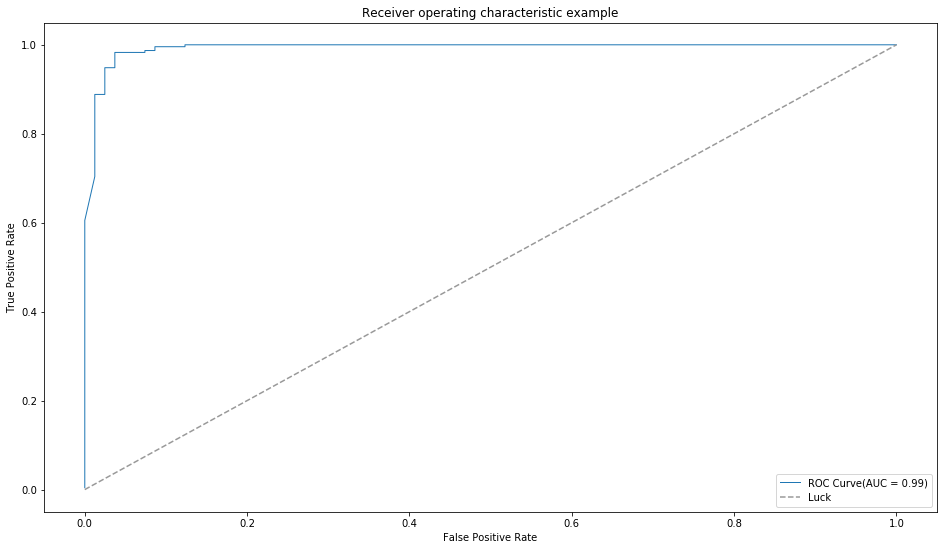

In [50]:
if __name__ == "__main__":
    
    #countvectorizer data is not standardized, should not be feed it to SVM
    #svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
    #% self.max_iter, ConvergenceWarning)
    #vectorizer = CountVectorizer(tokenizer = logProcessFuncs.tokenFunc, min_df = 1, max_df = 0.6,  max_features = 1000000)
    vectorizer = TfidfVectorizer(tokenizer = logProcessFuncs.tokenFunc, ngram_range=(1,4), min_df = 1, max_df = 0.6,  max_features = 1000000,use_idf=False)
    #do cleaning when load data
    #cleaner = utilDataPreprocess.CleanTextTransformer(n_jobs=2, cleanFunc=logProcessFuncs.cleanTextFunc)
    spliter = utilDataPreprocess.CleanTextTransformer(n_jobs=2, cleanFunc=logProcessFuncs.splitTextFunc)
    
    preprocess_pipline = Pipeline([
                     ("spliter", spliter),
                     ('vectorizer', vectorizer)])
    preprocessed_train_data = preprocess_pipline.fit_transform(X_train)
    preprocessed_test_data = preprocess_pipline.transform(X_test)
    
    """
    #base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
    #choose model:LinearSVC, SVC(kernel='linear'))
    clf1 = LinearSVC(verbose = True, random_state = 123, loss='hinge')
    #clf1 = LinearSVC(verbose = True, random_state = 123)
    parameters1={'C':[0.1, 0.5, 1, 10, 100], 'max_iter':[2000, 3000, 5000]}
    best_clf1 = gridSearchCLF(clf1, parameters1, preprocessed_train_data, y_train)
    print(best_clf1)
    
    predict1 = best_clf1.predict(preprocessed_test_data)
    score1 = accuracy_score(y_test, predict1)
    print("accuracy: LinearSVC:{}".format( score1)) 
    printNMostInformative(vectorizer.get_feature_names(), best_clf1.coef_[0], 30)
    print(classification_report(y_test, predict1))
    drawROCCurve(y_test, best_clf1.decision_function(preprocessed_test_data))
    """
    
    clf2 = SVC(kernel='linear',verbose = True, random_state = 123, max_iter = 100000, shrinking=False)
    parameters2={'C':[0.1, 1, 10,100], 'tol':[1e-1, 1e-2, 1e-3, 1e-4]}
    best_clf2 = gridSearchCLF(clf2, parameters2, preprocessed_train_data, y_train)
    print(best_clf2)    
    
    predict2 = best_clf2.predict(preprocessed_test_data)
    score2 = accuracy_score(y_test, predict2)
    print("accuracy: SVC with linearkernal:{}".format( score2))  
    printNMostInformative(vectorizer.get_feature_names(), best_clf2.coef_.toarray()[0], 30)
    print(classification_report(y_test, predict2))
    drawROCCurve(y_test, best_clf2.decision_function(preprocessed_test_data))